In [1]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg', 'pdf') # For export
#from matplotlib.colors import to_rgba
#import seaborn as sns
#sns.set()

## Progress bar
#from tqdm.notebook import tqdm


# Import pytorch libraries
import torch
import torch.nn as nn # neural network module
import torch.nn.functional as F # functional module
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.utils.data as data # loads datasets

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the dataset


In [2]:
# make dataset
# Set parameters
n_samples = 50

# make moons
from sklearn.datasets import make_moons
data_samples, label = make_moons(n_samples, noise=0.1, random_state=42) 


# # visualize the dataset
# plt.scatter(data_samples[:,0], data_samples[:,1], c=label)
# plt.show()

# create a dataset with the above data
moon_data = np.array(data_samples, dtype=np.float32)
moon_labels = np.array(label, dtype=np.float32)

**Create VFM model**

In [3]:
# create nn layers model
class hidden_VFM(nn.Module): # hidden layer
    def __init__(self, hidden_dimension=512):
        super().__init__()
        self.linear1 = nn.Linear(hidden_dimension, hidden_dimension)
        self.act = nn.SELU()

    def forward(self, x):
        #return self.act(self.linear1(x))  
        return x + self.act(self.linear1(x))  # residual connection 

class VFM_Model(nn.Module):
    def __init__(self, data_dimension, num_hidden, hidden_dimension, time_dimension): # TODO remove default values later
        super().__init__()

        self.time_dimension = time_dimension #embed time to vector

        self.input_dimension = data_dimension 
        self.hidden_dimension = hidden_dimension

        # project data and time into hidden dimension
        self.in_projection = nn.Linear(data_dimension + time_dimension, hidden_dimension)
        # hidden layers (does not contain in/out projections)
        self.hidden_layers = nn.Sequential(
            #nn.SELU(),
            *[hidden_VFM(hidden_dimension) for _ in range(num_hidden)], # list of hidden layers
        )
        # output projection
        self.out_projection = nn.Linear(hidden_dimension, data_dimension)

    # sinusoidal time embedding function, allows the model to understand at which time it is (see Transformers)
    def time_embed(self, t):
        # t: shape (batch,) or (batch,1)
        #t = t * 1000
        half_dim = self.time_dimension // 2
        # use torch/math for consistency and correct device handling
        emb_scale = -math.log(10000.0) / (half_dim - 1)
        freqs = torch.exp(torch.arange(half_dim, device=t.device, dtype=torch.float32) * emb_scale)
        t = t.to(dtype=torch.float32)
        emb = t[:, None] * freqs[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

    def forward(self, x, t):
        t = self.time_embed(t)
        x_input = torch.cat([x, t], dim=-1) # concatenate input and time embedding
        x = self.in_projection(x_input) # project input to hidden dimension

        x = self.hidden_layers(x) # pass through hidden layers        
        mu_pred = self.out_projection(x) # predicted mean of x_1

        return mu_pred

In [4]:

# Training
def train_model(model, training_data, training_steps, batch_size, optim, scheduler, losses):
    pbar = tqdm(range(training_steps))
    for step in pbar:
        optim.zero_grad()

        # Sample a batch of data x_1
        indices = torch.randint(0, len(training_data), (batch_size,), device=training_data.device) 
        x_1 = training_data[indices]

        # Sample noise data x_0
        x_0 = torch.randn_like(x_1)

        # Sample random time between 0 and 1 on the correct device
        t = torch.rand(x_1.size(0), device=x_1.device)

        # Interpolate between x_0 and x_1
        x_t = (t[:, None] * x_1) + (1 - t[:, None]) * x_0 

        # Predict the velocity using the model
        mu_pred = model(x_t, t) 

        # Compute the loss (assuming the variational distribution is a multivariate gaussian and the data is continuous)
        loss = torch.mean((mu_pred - x_1)**2) # compares nn output to the true data point --> nn becomes a true data destination predictor (will thereby try to predict the mean of true data points)

        # Backpropagation and optimization step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.02)
        optim.step()
        scheduler.step()

        # Update progress bar
        current_lr = scheduler.get_last_lr()[0]
        pbar.set_postfix(loss=loss.item(), lr=f"{current_lr:.2e}")
        losses.append(loss.item())

In [5]:
n_samples = 1000
data_samples, label = make_moons(n_samples, noise=0.1, random_state=42) 
num_hidden = 8
hidden_dimension = 256

# normalize data
data_mean = data_samples.mean(axis=0)
data_std = data_samples.std(axis=0)
normalized_data = (data_samples - data_mean) / data_std

training_data = torch.tensor(normalized_data, dtype=torch.float32).to(device)
training_labels = torch.tensor(label, dtype=torch.float32).to(device)

VFM_model_1 = VFM_Model(data_dimension=2, num_hidden=num_hidden, hidden_dimension=hidden_dimension, time_dimension=16).to(device)
optim = torch.optim.AdamW(VFM_model_1.parameters(), lr=1e-4) 

training_steps = 40000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max = training_steps, eta_min=1e-6)


batch_size = 256
losses = [] #TODO replace based on loss function (corss entropy etc)

train_model(VFM_model_1, training_data,  training_steps, batch_size, optim, scheduler, losses)

100%|██████████| 40000/40000 [06:47<00:00, 98.18it/s, loss=0.541, lr=1.00e-06] 


Text(0.5, 1.0, 'Training Loss over Time')

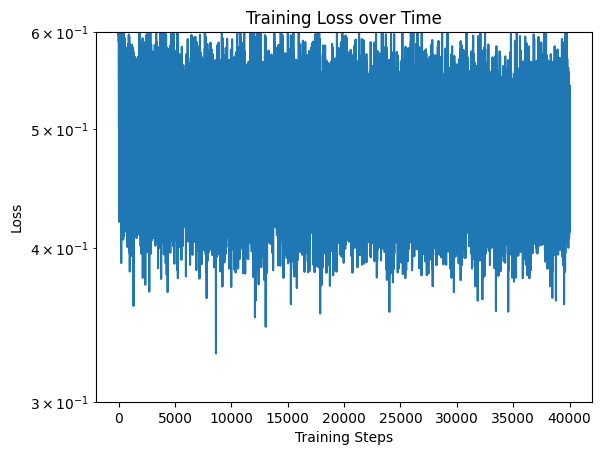

In [6]:
#plot loss in log scale
from matplotlib import pyplot

pyplot.plot(losses)
pyplot.yscale('log')
pyplot.ylim(0.3, 0.6)
#plt.plot(losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss over Time")

**Create Classifier**

In [7]:
# create nn layers model
class hidden_VFM(nn.Module): # hidden layer
    def __init__(self, hidden_dimension=512):
        super().__init__()
        self.linear1 = nn.Linear(hidden_dimension, hidden_dimension)
        self.act = nn.SELU()

    def forward(self, x):
        #return self.act(self.linear1(x))  
        return x + self.act(self.linear1(x))  # residual connection 

class Classifier(nn.Module):
    def __init__(self, data_dimension, num_hidden, hidden_dimension, time_dimension, num_classes): # TODO remove default values later
        super().__init__()

        self.time_dimension = time_dimension #embed time to vector

        self.input_dimension = data_dimension 
        self.hidden_dimension = hidden_dimension

        # project data and time into hidden dimension
        self.in_projection = nn.Linear(data_dimension + time_dimension, hidden_dimension)
        # hidden layers (does not contain in/out projections)
        self.hidden_layers = nn.Sequential(
            #nn.SELU(),
            *[hidden_VFM(hidden_dimension) for _ in range(num_hidden)], # list of hidden layers
        )
        # output projection
        self.out_projection = nn.Linear(hidden_dimension, num_classes)

    # sinusoidal time embedding function, allows the model to understand at which time it is (see Transformers)
    def time_embed(self, t):
        # t: shape (batch,) or (batch,1)
        #t = t * 1000
        half_dim = self.time_dimension // 2
        # use torch/math for consistency and correct device handling
        emb_scale = -math.log(10000.0) / (half_dim - 1)
        freqs = torch.exp(torch.arange(half_dim, device=t.device, dtype=torch.float32) * emb_scale)
        t = t.to(dtype=torch.float32)
        emb = t[:, None] * freqs[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

    def forward(self, x, t):
        t = self.time_embed(t)
        x_input = torch.cat([x, t], dim=-1) # concatenate input and time embedding
        x = self.in_projection(x_input) # project input to hidden dimension

        x = self.hidden_layers(x) # pass through hidden layers        
        label = self.out_projection(x) # predicted mean of x_1

        return label

In [8]:
# Training
def train_model(model, training_data, training_labels, training_steps, batch_size, optim, scheduler, losses):
    entropy = nn.CrossEntropyLoss() # cross entropy loss for classification loss
    pbar = tqdm(range(training_steps))
    for step in pbar:
        optim.zero_grad()

        # Sample a batch of data x_1
        indices = torch.randint(0, len(training_data), (batch_size,), device=training_data.device) 
        x_1 = training_data[indices]
        y = training_labels[indices].long() # long tensor for cross entropy loss

        # Sample noise data x_0
        x_0 = torch.randn_like(x_1)

        # Sample random time between 0 and 1 on the correct device
        t = torch.rand(x_1.size(0), device=x_1.device)

        # Interpolate between x_0 and x_1
        x_t = (t[:, None] * x_1) + (1 - t[:, None]) * x_0 

        # Predict the label using the model
        y_pred = model(x_t, t) 

        # Compute the loss (assuming the variational distribution is a multivariate gaussian and the data is continuous)
        loss = entropy(y_pred, y) # compares nn output to the true data label --> nn becomes a true data destination predictor (will thereby try to predict the mean of true data points)

        # Backpropagation and optimization step
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.02)
        optim.step() # adjust param by its gradient
        scheduler.step()

        # Update progress bar
        current_lr = scheduler.get_last_lr()[0]
        pbar.set_postfix(loss=loss.item(), lr=f"{current_lr:.2e}")
        losses.append(loss.item())

In [9]:
# train the model
n_samples = 1000
data_samples, label = make_moons(n_samples, noise=0.1, random_state=42) 
num_hidden = 5
hidden_dimension = 128

# normalize data
data_mean = data_samples.mean(axis=0)
data_std = data_samples.std(axis=0)
normalized_data = (data_samples - data_mean) / data_std

training_data = torch.tensor(normalized_data, dtype=torch.float32).to(device)
training_labels = torch.tensor(label, dtype=torch.float32).to(device)

Classifier_1 = Classifier(data_dimension=2, num_hidden=num_hidden, hidden_dimension=hidden_dimension, time_dimension=16, num_classes=2).to(device)
optim = torch.optim.AdamW(Classifier_1.parameters(), lr=1e-4) 

training_steps = 20000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max = training_steps, eta_min=1e-6)


batch_size = 32
losses = [] 

train_model(Classifier_1, training_data,  training_labels, training_steps, batch_size, optim, scheduler, losses)

100%|██████████| 20000/20000 [01:27<00:00, 227.45it/s, loss=0.62, lr=1.00e-06] 


**Inference**

In [38]:
# Generation

def generate_model(model, classifier, test_size, num_steps, target_label, guidance_scale):
    model.eval() # set model to evaluation mode
    classifier.eval() # set classifier to evaluation mode

    # start with pure noise
    x_current = torch.randn(test_size, 2).to(device) # generate test_size number of 2D random noises (feature 1, feature 2)
    dt = 1 / num_steps # step sizes going from x_0 to x_1

    # integrate from t=0 to t=1
    for i in range(num_steps):
        # at current time
        t_scalar = i / num_steps
        t_current = torch.ones(test_size, device=device) * t_scalar

        # compute velocity at time t_current
        with torch.no_grad():
            # compute target
            mu_t = model(x_current, t_current) # predict target end point

            # calculate velocity towards target
            if (1-t_scalar) < 0.05: # for stability
                v_t = (mu_t - x_current) / (0.05)
            else:
                v_t = (mu_t - x_current) / (1 - t_current[:, None]) 
            
        # compute guidance
        x_current = x_current.detach().requires_grad_(True)
        with torch.enable_grad():
            # predict label at current x_t and t, e.g. [0.2, 0.8]
            logits = classifier(x_current, t_current)  # renamed to avoid overwriting classifier!
            # calculte log
            log_probs = F.log_softmax(logits, dim=-1) # use softmax to get valid log probabilities (avoid negatives)
            # consider only target label probability
            log_prob_target = log_probs[:, target_label].sum()
            # calculate gradient wrt x_t
            grad_log_classifier = torch.autograd.grad(log_prob_target, x_current)[0]

        # calculate guided velocity
        v_t_guided = v_t + guidance_scale * (1-t_scalar) * grad_log_classifier

        # perform next step with the calculated velocity
        x_next = x_current + v_t_guided * dt

        x_current = x_next.detach() # avoid accumulating gradients across iterations

    return x_current

In [63]:
test_size = 1000
num_steps = 100
target_label = 0
guidance_scale = 2.2

generated_data = generate_model(VFM_model_1, Classifier_1, test_size, num_steps, target_label, guidance_scale).cpu().numpy()

# unnormalize generated data
unnormalized_generated_data = generated_data * data_std + data_mean

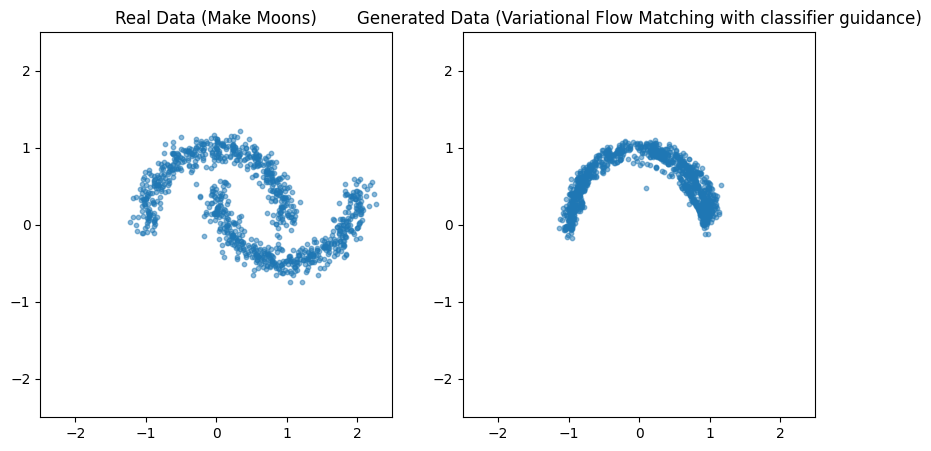

In [64]:
# Visual Comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(data_samples[:, 0], data_samples[:, 1], alpha=0.5, s=10)
plt.title("Real Data (Make Moons)")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)

plt.subplot(1, 2, 2)
plt.scatter(unnormalized_generated_data[:, 0], unnormalized_generated_data[:, 1], alpha=0.5, s=10)
plt.title("Generated Data (Variational Flow Matching with classifier guidance)")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
#plt.savefig("Simple_tClassifier_VFM_31012026_s0.6.png")
plt.show()

In [13]:
# state_dict = FM_model_1.state_dict() # parameters values
# #print(state_dict)

# torch.save(state_dict, "Simple_FM_model_01102025_numhidden5_hiddendim256_strainingsteps20000_batchsizes4096.tar")

In [14]:
# # Evaluate the model
# accuracy = evaluate_model(FM_model_1, test_data, test_labels, test_batch_size)
# print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [15]:
# Quick smoke test for FM_model_1
# This cell checks a forward pass and that shapes / devices are consistent
x_t = torch.randn(4, 2).to(device)
t = torch.rand(4, device=device)
v_pred = FM_model_1(x_t, t)
print("v_pred.shape:", v_pred.shape)
print("v_pred device:", v_pred.device)
print("Sample values:\n", v_pred[:2])

NameError: name 'FM_model_1' is not defined